In [1]:
%%capture
# Observação: para utilizar o scikeras, precisamos manter a versão do scikit-learn em 1.5.2.
# Versões a partir da 1.6 introduziram alterações que, no momento, não são compatíveis com o scikeras.
!pip install scikit-learn==1.5.2
!pip install scikeras

In [2]:
# Aviso: reinicie o runtime caso a versão mostrada não seja 1.5.2
import sklearn
print(sklearn.__version__)

1.5.2


# 1. Visão geral e preparação

O conjunto de dados Fashion MNIST é amplamente utilizado como um ponto de partida no aprendizado de redes neurais para visão computacional. Ele contém 70.000 imagens em tons de cinza (28 × 28 pixels), divididas em 10 categorias de roupas e acessórios, como Camiseta, Calça, Pulôver, Vestido, entre outros.
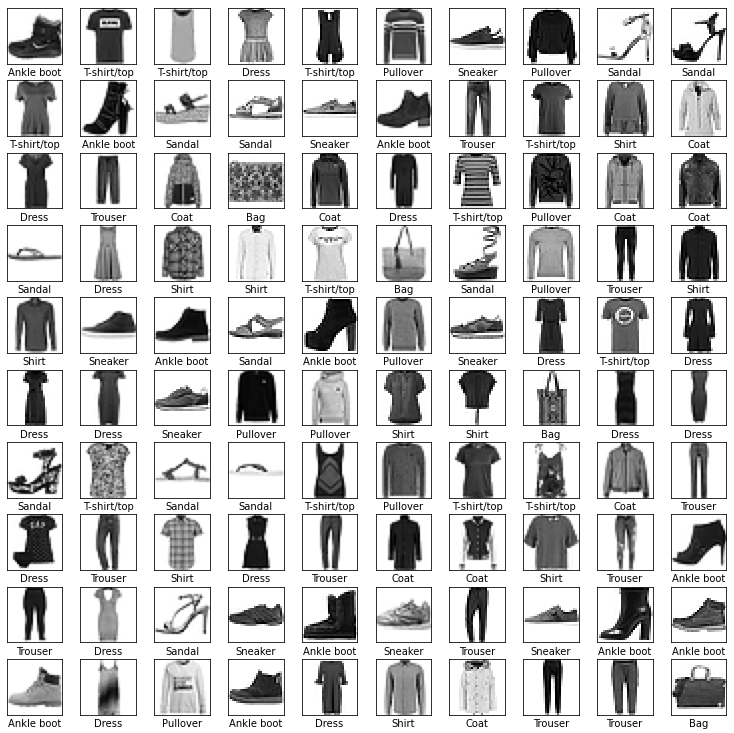
* 60.000 imagens são reservadas para treino (training set).
* 10.000 imagens são reservadas para teste (test set).

Cada imagem possui um rótulo (de 0 a 9), correspondendo a um tipo de roupa. O objetivo é treinar um modelo de rede neural que, dada a imagem de uma peça de roupa, seja capaz de prever corretamente a categoria a que ela pertence.

# 2. Importando bibliotecas e carregando o conjunto de dados

Nesta etapa, importamos as bibliotecas fundamentais do nosso projeto:

* TensorFlow (Keras): para construir e treinar redes neurais.
* NumPy: para manipulação de arrays (estruturas comumente usadas em dados e imagens).
* Matplotlib: para visualização de imagens e geração de gráficos.

Em seguida, fazemos o download (ou carregamos do cache) do Fashion MNIST por meio de tf.keras.datasets.fashion_mnist.load_data(), que já separa automaticamente os dados em conjuntos de treino e teste.

In [5]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

2025-03-17 14:45:05.509079: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 14:45:05.512335: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 14:45:05.522068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742233505.539335   11900 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742233505.544291   11900 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742233505.556627   11900 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [6]:
# Carregando Fashion MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# Checando tamanhos dos conjuntos
print('Tamanho do x_train:', x_train.shape)
print('Tamanho do y_train:', y_train.shape)
print('Tamanho do x_test: ', x_test.shape)
print('Tamanho do y_test: ', y_test.shape)

Tamanho do x_train: (60000, 28, 28)
Tamanho do y_train: (60000,)
Tamanho do x_test:  (10000, 28, 28)
Tamanho do y_test:  (10000,)


# 3. Normalização das imagens

Como cada pixel da imagem varia entre 0 e 255 (representando diferentes tons de cinza), realizamos a normalização dividindo por 255. Esse processo ajusta os valores para o intervalo [0, 1], o que ajuda a rede a aprender de maneira mais estável e eficiente.

In [8]:
x_train = x_train / 255.0
x_test = x_test / 255.0

# 4. Visualizando algumas imagens e seus rótulos

É sempre útil inspecionar algumas amostras dos dados antes de treinarmos qualquer modelo. Isso nos dá uma visão clara de como as imagens são representadas e quais classes (rótulos) existem.

Para isso, usamos o imshow do Matplotlib, exibindo algumas imagens junto com seus rótulos. Aqui, cada rótulo numérico (0 a 9) corresponde a uma classe de roupa, como “Camiseta/Top”, “Calça”, “Pulôver” etc.

In [9]:
# Listando nomes de classes, correspondendo aos valores de 0 a 9
nomes_classes = ['Camiseta/Top',   # 0
                 'Calça',          # 1
                 'Pulôver',        # 2
                 'Vestido',        # 3
                 'Casaco',         # 4
                 'Sandália',       # 5
                 'Camisa',         # 6
                 'Tênis',          # 7
                 'Bolsa',          # 8
                 'Bota']           # 9

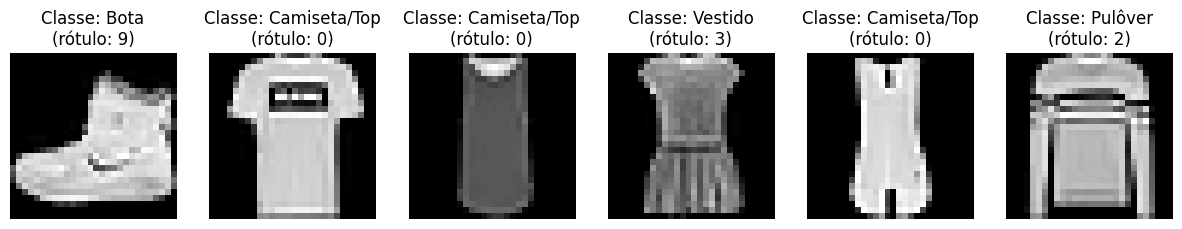

In [10]:
# Mostrando as 6 primeiras imagens em subplots
fig, axes = plt.subplots(1, 6, figsize=(15, 3))

for i in range(6):
  axes[i].imshow(x_train[i], cmap='gray')
  axes[i].set_title(f'Classe: {nomes_classes[y_train[i]]}\n(rótulo: {y_train[i]})')
  axes[i].axis('off')

plt.show()

# 5. Construindo o modelo

Vamos criar um modelo de rede neural simples, do tipo Rede Neural Densa (também conhecida como MLP – Multilayer Perceptron). Embora redes neurais densas não sejam as mais adequadas para processamento de imagens (as melhores são as Redes Convolucionais), elas servem como uma primeira experiência didática.

Estrutura do modelo
1. Camada de Entrada (Input): Define o formato dos dados. Informamos que cada amostra de entrada tem dimensões 28 × 28.
2. Camada de Achatamento (Flatten): Converte a imagem 28 × 28 em um vetor 1D de 784 posições, para que possamos conectar às camadas densas.
<center>
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*_Cb1dzBhciwRi9y1-J6qjQ.png" width="350">
</center>
3. Camada Densa (128 neurônios, ReLU): Camada totalmente conectada (FC) com a função de ativação ReLU (Rectified Linear Unit). Essa função ajuda o modelo a aprender relações complexas, pois introduz não-linearidade.
<center>
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*_EUZwts1kcl_VcaF4XOdwQ.png" width="300">
</center>
4. Camada de Saída (10 neurônios, Softmax): Camada de saída que retorna as probabilidades para cada uma das 10 classes. O softmax garante que a soma das probabilidades seja 1, interpretando cada saída como uma categoria diferente.
<center>
<img src="https://images.contentstack.io/v3/assets/bltac01ee6daa3a1e14/blt47d8c9956d11ec40/65ef897139973e081a6e697c/img_blog_BP-PB-Understanding-the-Softmax-Activation-Function_-A-Comprehensive-Guide_new-primary.png?width=1440&disable=upscale&auto=webp" width="300"><img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2017/11/softmax1.png?resize=850%2C329&ssl=1" width="450">
</center>


Parâmetros de compilação
* Otimizador (optimizer='adam'): Ajusta os pesos da rede de forma automática e eficiente durante o treino.
* Função de perda (loss='sparse_categorical_crossentropy'): Usada para problemas de classificação multiclasse, onde os rótulos são inteiros (0 a 9).
* Métrica (metrics=['accuracy']): Acurácia é a porcentagem de acertos que o modelo obteve (proporção de imagens corretamente classificadas).

In [11]:
model = tf.keras.Sequential([
  # Definindo o formato dos dados que entrarão na rede
  tf.keras.layers.Input(shape=(28, 28)),

  # Transformando 28x28 em um vetor de 784 posições
  tf.keras.layers.Flatten(),

  # Adicionando primeira camada densa com 128 neurônios
  tf.keras.layers.Dense(128, activation='relu'),

  # Finalizando com camada final com 10 neurônios (10 classes)
  tf.keras.layers.Dense(10, activation='softmax')
])
    # Opções de funções de ativação
      # activation='relu'  # Função mais comum, usada em camadas ocultas
      # activation='sigmoid'  # Para saída binária (0 ou 1)
      # activation='softmax'  # Para classificação multiclasse
      # activation='tanh'  # Alternativa ao ReLU, pode ser útil para dados normalizados
      # activation='linear'  # Retorna a entrada sem modificar, útil em regressões


  # Configuração do modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  ## Alternativas dos parâmetros acima:
  #1 Opções de otimizadores
      # optimizer='sgd'  # Stochastic Gradient Descent (descida do gradiente estocástica)
      # optimizer='adam'  # Adaptive Moment Estimation (Adam), muito usado
      # optimizer='adagrad'  # Adaptive Gradient, ajusta taxa de aprendizado automaticamente
      # optimizer='nadam'  # Nesterov-accelerated Adaptive Moment Estimation, variação do Adam
  #2 Opções de funções de perda (loss)
      # loss='categorical_crossentropy'  # Para classificação multiclasse com one-hot encoding
      # loss='sparse_categorical_crossentropy'  # Para classificação multiclasse com labels inteiros
      # loss='binary_crossentropy'  # Para classificação binária (0 ou 1)
      # loss='mean_squared_error'  # Erro quadrático médio, usado em regressão
      # loss='mean_absolute_error'  # Erro absoluto médio, penaliza menos que MSE
      # loss='huber'  # Combinação de MSE e MAE, útil para lidar com outliers
  #3 Opções de métricas de avaliação (colocar quantas quiser)
      # metrics=['accuracy']  # Para classificação com classes balanceadas
      # metrics=['precision', 'recall']  # Para problemas desbalanceados
      # metrics=['mse']  # Mean Squared Error, usado para regressão
      # metrics=['mae']  # Mean Absolute Error, usado para regressão



# Mostra a estrutura do modelo
model.summary()

E0000 00:00:1742233849.424945   11900 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1742233849.425882   11900 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Como foram calculados os valores da coluna Param?
<center>
<img src="https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEgZ1onrToMXESCQG6HBk-eOF9Hp1LYt_-dz8H4TcP_e4XkgECQyosZ7Y1NUAibzwGYvCllH2IfMrBHXE9RbH4C_KnhkOa3E382hst8LzqyfwUMTSdolM8GZha_w4shhNbRZIUFeS9H9c4Blwke5bKs5Jfn8-3gd_BhzsSptBBoYbD3YaJJCbYCV--xIvA/w584-h329/Neural%20network%20weights%20and%20bias%20(1).png" width="400">
</center>

# 6. Treinando o modelo

O treinamento do modelo é feito chamando model.fit(x_train, y_train, epochs=..., validation_split=...). Neste exemplo:

* Definindo o callback EarlyStopping: O treinamento será interrompido se o critério de monitoramento 'val_loss' não melhorar por 5 épocas consecutivas
* restore_best_weights=True: O resultado que realmente será utilizado será o melhor, mesmo que não seja o último
* epochs=20: Quer dizer que a rede passará no máximo 20 vezes pelo conjunto de treino.
* validation_split=0.2: Separa automaticamente 20% do conjunto de treino para validação interna. Isso nos permite acompanhar se o modelo está se adaptando bem ou começando a “decorar” os dados (overfitting).

O objeto retornado (historico) armazena informações sobre a perda (loss) e a acurácia de treino/validação em cada época, permitindo analisar depois a evolução do aprendizado do modelo.

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Opções de monitoramento para EarlyStopping
    # monitor='val_loss'  # Perda no conjunto de validação (mais comum)
    # monitor='loss'  # Perda no conjunto de treino
    # monitor='val_accuracy'  # Acurácia no conjunto de validação
    # monitor='accuracy'  # Acurácia no conjunto de treino
historico = model.fit(x_train, y_train,
                      epochs=20,
                      validation_split=0.2,  # 20% dos dados de treino serão usados para validação
                      callbacks=[early_stopping])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7671 - loss: 0.6582 - val_accuracy: 0.8443 - val_loss: 0.4295
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8589 - loss: 0.3899 - val_accuracy: 0.8474 - val_loss: 0.4136
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8750 - loss: 0.3457 - val_accuracy: 0.8741 - val_loss: 0.3489
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8820 - loss: 0.3200 - val_accuracy: 0.8686 - val_loss: 0.3573
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8908 - loss: 0.2949 - val_accuracy: 0.8787 - val_loss: 0.3423
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8941 - loss: 0.2868 - val_accuracy: 0.8721 - val_loss: 0.3509
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9002 - loss: 0.2715 - val_accuracy: 0.8745 - val_loss: 0.3523
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9047 - loss: 0.2602 - 

# 7. Analisando o desempenho

Para avaliar o desempenho real do modelo em dados nunca vistos durante o treino, usamos o método model.evaluate no conjunto de teste (x_test e y_test). Isso nos dá a perda final e a acurácia final do modelo em um cenário que simula dados reais.

In [13]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Acurácia no conjunto de teste: {test_acc:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8899 - loss: 0.3336
Acurácia no conjunto de teste: 0.89


# 8. Visualizando a curva de acurácia e de perda
Ao longo das épocas de treino, tanto a acurácia quanto a perda (loss) vão se modificando. Podemos plotar esses valores para entender se nosso modelo está aprendendo ou se começa a apresentar overfitting (quando a acurácia de treino sobe, mas a acurácia de validação não acompanha).

* historico.history['accuracy']: acurácia no treino, época a época.
* historico.history['val_accuracy']: acurácia na validação.
* historico.history['loss'] e historico.history['val_loss']: perda no treino e na validação, respectivamente.

Verificar esses gráficos nos ajuda a decidir se precisamos treinar por mais épocas, mudar a arquitetura da rede ou aplicar técnicas de regularização (por exemplo, Dropout ou Batch Normalization).

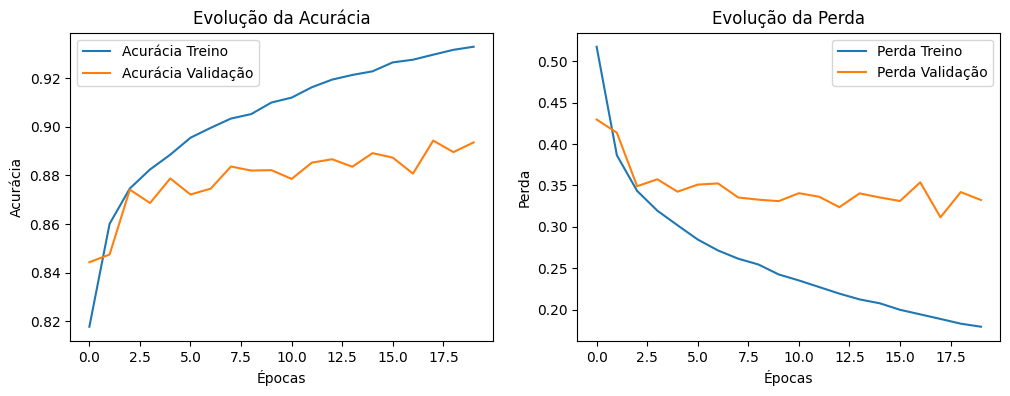

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plotando a acurácia
ax1.plot(historico.history['accuracy'], label='Acurácia Treino')
ax1.plot(historico.history['val_accuracy'], label='Acurácia Validação')
ax1.set_title('Evolução da Acurácia')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Acurácia')
ax1.legend()

# Plotando a perda
ax2.plot(historico.history['loss'], label='Perda Treino')
ax2.plot(historico.history['val_loss'], label='Perda Validação')
ax2.set_title('Evolução da Perda')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Perda')
ax2.legend()

plt.show()

# 9. Comparando previsões com rótulos reais

Depois de treinado, podemos ver exemplos práticos de classificação. Ao chamar model.predict(x_test), recebemos um vetor de probabilidades para cada imagem. O índice com a maior probabilidade representa a classe prevista.

Ao comparar isso com o rótulo real (armazenado em y_test), vemos se o modelo acertou ou errou. Visualizar alguns exemplos de acertos e erros é fundamental para interpretar o comportamento do modelo.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step


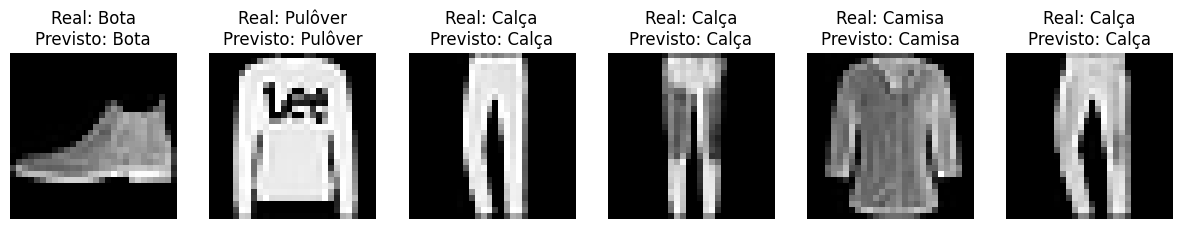

In [15]:
# Gerando probabilidades para cada imagem
predictions = model.predict(x_test)

# Visualizando algumas previsões
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
  axes[i].imshow(x_test[i], cmap='gray')
  axes[i].set_title(f'Real: {nomes_classes[y_test[i]]}\n'
  f'Previsto: {nomes_classes[np.argmax(predictions[i])]}')
  axes[i].axis('off')

plt.show()

# 10. Observando erros de classificação

Mesmo um modelo bem treinado não será perfeito. Ao inspecionar manualmente os casos onde há erro (por exemplo, uma bolsa classificada como calça), podemos entender melhor:

* Se há confusão natural entre categorias (por exemplo, dependendo do ângulo, uma “camisa” pode se assemelhar a um “pulôver”).
* Se o modelo não teve dados suficientes para certas classes.
* Se há necessidade de um modelo mais complexo, como uma Rede Convolucional.

Isso também ajuda a tomar decisões sobre limpeza ou aumento do conjunto de dados (data augmentation).

Total de erros no conjunto de teste: 1109


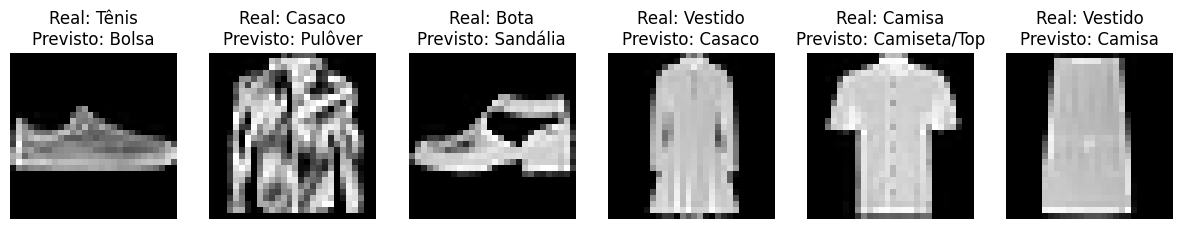

In [16]:
# Criando uma lista de índices de onde o modelo errou
predicoes_labels = np.argmax(predictions, axis=1)
indices_errados = np.where(predicoes_labels != y_test)[0]

print(f'Total de erros no conjunto de teste: {len(indices_errados)}')

# Exibindo as 6 primeiras imagens onde o modelo errou
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i, idx in enumerate(indices_errados[:6]):
  axes[i].imshow(x_test[idx], cmap='gray')
  axes[i].set_title(f'Real: {nomes_classes[y_test[idx]]}\n'
  f'Previsto: {nomes_classes[predicoes_labels[idx]]}')
  axes[i].axis('off')

plt.show()

# 11. Conclusões e próximos passos

Acurácia típica:
  - Com essa arquitetura densa simples, costuma-se atingir de 85% a 90% de acurácia no teste.

Melhorias:
  - Usar Camadas Convolucionais (CNN), que são especialmente adequadas para imagens, podendo elevar a acurácia para acima de 92%.
  - Regularização (como Dropout e Batch Normalization) para evitar que o modelo decore o conjunto de treino.
  - Ajustar hiperparâmetros, como número de neurônios e camadas.

Em resumo, aprendemos:
  - Como carregar o Fashion MNIST (ou qualquer outro conjunto de dados fornecido pelo Keras).
  - Como preparar e normalizar os dados de entrada.
  - Como construir um modelo simples (MLP) no Keras.
  - Como treinar, validar e avaliar o desempenho do modelo.
  - Como inspecionar visualmente os resultados, tanto acertos quanto erros.

# 12. Matriz de Confusão (Bônus)

Apesar de observarmos manualmente alguns erros de classificação, outra forma de analisar o desempenho do modelo é por meio da Matriz de Confusão. Ela mostra, para cada classe real, como as previsões foram distribuídas nas classes previstas, facilitando a visualização de quais classes o modelo mais confunde.

No caso do Fashion MNIST (10 classes), a matriz resultante terá dimensão 10×10. Linhas representam a classe real e colunas representam a classe prevista. Quanto mais concentrados os valores estiverem na diagonal principal (células onde classe real = classe prevista), melhor o desempenho do modelo.

<Figure size 3000x800 with 0 Axes>

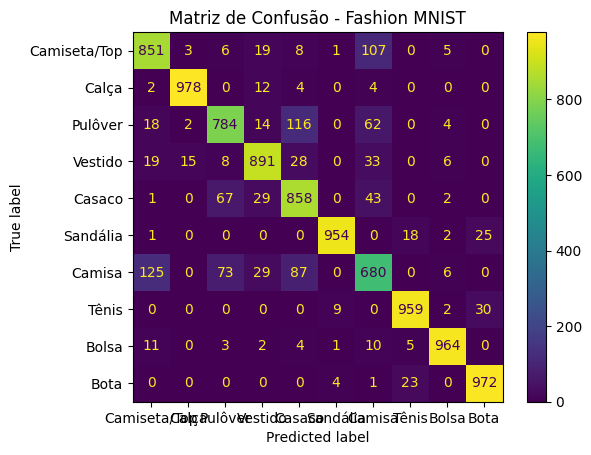

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convertendo as previsões (probabilidades) para o índice da classe de maior probabilidade
predicoes_classes = np.argmax(predictions, axis=1)

# Gerando a matriz de confusão
cm = confusion_matrix(y_test, predicoes_classes)

# Ajustando o tamanho da figura
# Seria isso pra alterar, mas não está funcionando nem com reza
plt.figure(figsize=(30, 8))

# Exibindo a matriz de confusão de forma gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nomes_classes)
disp.plot() # values_format='.0f'
plt.title('Matriz de Confusão - Fashion MNIST')
plt.show()

# 13. Cross-Validation (Bônus)

A Validação Cruzada (Cross-Validation) é uma técnica onde o conjunto de dados é dividido em múltiplas partes (folds) para teste/validação e treino de forma iterativa, aumentando a confiabilidade das métricas. No contexto de um dataset como o Fashion MNIST, onde há 60.000 amostras de treino, aplicar a validação cruzada pode ser computacionalmente custoso, mas fornece estimativas mais robustas de desempenho.

Aviso: Dependendo da quantidade de folds e do tamanho do Fashion MNIST, esse processo pode levar muito tempo. Em aplicações reais, pode ser interessante trabalhar com uma parte reduzida dos dados ou usar estratégias para acelerar o treinamento (GPU, TPU, etc.).

A ideia é criar uma função que retorne uma rede neural, encapsular isso em um estimator compatível com o scikit-learn e, em seguida, chamar cross_val_score definindo o número de partições cv.

In [18]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score

In [19]:
# Encapsulando a criação da rede neural em uma função
def criar_rede_cross():

  # Limpando o cache de qualquer sessão anterior para evitar sobreposição de modelos
  tf.keras.backend.clear_session()

  # Mesma arquitetura de rede que implementamos anteriormente
  model = tf.keras.models.Sequential([tf.keras.layers.Input(shape=(28, 28)),
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dense(units=128, activation='relu'),
                                      tf.keras.layers.Dense(units=10, activation='softmax')])

  # Compilando a rede
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [20]:
# Criando um objeto KerasClassifier
# Mantemos 10 épocas (como no primeiro exemplo) e definimos batch_size=256 (batch grande) para agilizar o treinamento.
rede_cv = KerasClassifier(model=criar_rede_cross,
                         epochs=10,
                         batch_size=256)

In [21]:
# Exemplo de uso do cross_val_score
resultados = cross_val_score(estimator=rede_cv,
                             X=x_train,
                             y=y_train,
                             cv=3,    # Exemplo: 3 "folds" de validação
                             scoring='accuracy')

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6785 - loss: 0.9539
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8403 - loss: 0.4659
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8534 - loss: 0.4190
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8674 - loss: 0.3874
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8727 - loss: 0.3666
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8785 - loss: 0.3487
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8791 - loss: 0.3457
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8819 - loss: 0.3268
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8914 - loss: 0.3065
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8951 - loss: 0.2975
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6834 - loss: 0.9534
Epoch 2/10
157

In [22]:
print('Acurácias obtidas em cada dobra (fold):', resultados)
print('Média das acurácias:', resultados.mean())
print('Desvio padrão:', resultados.std())

Acurácias obtidas em cada dobra (fold): [0.85935 0.88345 0.8746 ]
Média das acurácias: 0.8724666666666666
Desvio padrão: 0.009953754177305285


Explicação:
* cv=3 significa que os dados foram divididos em 3 partes. A cada iteração, 1 parte é usada para validação e as outras 2 para treino.
* resultados conterá 3 valores de acurácia (um para cada iteração).
* A média (mean()) e o desvio padrão (std()) indicam a estabilidade do modelo. Se o desvio for muito alto, significa que o resultado varia bastante conforme a divisão dos dados.

# 14. Fine Tuning (Bônus)
O Fine Tuning (ou Hiperparametrização) permite experimentar diferentes configurações para otimizar o desempenho da rede, como função de ativação, número de neurônios, tipo de inicializador de pesos, tamanho de batch, etc.

Podemos organizar esse processo com o GridSearchCV, que internamente já utiliza a técnica de validação cruzada para calcular os valores de acurácia. Isto é, o GridSearchCV (onde “CV” significa Cross-Validation) faz a busca em grade ao mesmo tempo em que realiza a validação cruzada. Para cada combinação de hiperparâmetros, o algoritmo divide o conjunto de dados em “k” partes (folds), treinando o modelo em “k-1” partes e validando na parte restante. Ele repete esse processo para todos os folds, obtendo uma média de desempenho (por exemplo, acurácia) para aquela combinação de parâmetros. Em seguida, passa para a próxima combinação, até avaliar todas elas. Dessa forma, além de testar vários conjuntos de parâmetros, o GridSearchCV também retorna uma estimativa mais confiável do desempenho real do modelo, pois cada combinação é testada várias vezes em diferentes divisões do dataset.

Aviso: Assim como a validação cruzada, fazer Grid Search no Fashion MNIST pode demandar muito tempo de processamento. Cada combinação de parâmetros será treinada e validada repetidas vezes. Em problemas do mundo real, costuma-se rodar esse processo em servidores com GPU, e às vezes ainda se recorre a buscas mais inteligentes (como Random Search ou Bayesian Optimization) em vez de testar todas as combinações.

In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
# Função para criar uma rede com parâmetros variáveis
def criar_rede_finetuning(optimizer, kernel_initializer, activation, neurons):
  # Limpando o cache de qualquer sessão anterior para evitar sobreposição de modelos
  tf.keras.backend.clear_session()

  # Mesma arquitetura de rede que implementamos anteriormente
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.InputLayer(shape=(28, 28)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=neurons,
                                  activation=activation,
                                  kernel_initializer=kernel_initializer))
  model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

  # Compilando a rede
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [25]:
# Encapsulando a função de criação de rede em um KerasClassifier, para uso com scikit-learn
classificador = KerasClassifier(model=criar_rede_finetuning)

# Definindo o dicionário de parâmetros para o GridSearch
# Observações:
# - Algumas listas possuem apenas 1 item (por exemplo, 'model__optimizer'), pois queremos restringir a busca
#   para fins de demonstração ou otimização de tempo. Poderíamos adicionar outras opções se desejado.
# - 'batch_size' não está definido dentro da função 'criar_rede_finetuning', mas o KerasClassifier reconhece
#   esse parâmetro de forma externa, aplicando-o internamente durante o fit.
parametros = {
    'batch_size': [64, 128],        # Testando dois tamanhos diferentes
    'epochs': [5],                  # Usando poucas épocas para diminuir o tempo de execução
    'model__optimizer': ['adam'],   # Poderíamos adicionar outras opções como 'sgd', 'rmsprop' etc.
    'model__kernel_initializer': ['random_uniform'],
    'model__activation': ['relu'],  # Outras opções possíveis: 'tanh', 'sigmoid', etc.
    'model__neurons': [64, 128]     # Variação no número de neurônios da camada oculta
}

In [26]:
# Montando o objeto GridSearchCV com 3 partes de validação cruzada (cv=3).
# Isso significa que para cada combinação de parâmetros, o conjunto de treino
# será dividido em 3 folds: treinamos com 2 e validamos com o 1 restante,
# repetindo o processo 3 vezes e calculando a média de desempenho.
grid_search = GridSearchCV(estimator=classificador,
                           param_grid=parametros,
                           cv=3)

# Ajustando (treinando) o modelo com cada combinação de hiperparâmetros.
# Para esse exemplo, usamos x_train e y_train do Fashion MNIST.
grid_search.fit(x_train, y_train)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7346 - loss: 0.7830
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8449 - loss: 0.4387
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8596 - loss: 0.3946
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8689 - loss: 0.3729
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8725 - loss: 0.3538
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7409 - loss: 0.7742
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8433 - loss: 0.4496
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8644 - loss: 0.3811
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8710 - loss: 0.3596
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8701 - loss: 0.3560
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0

GridSearchCV(cv=3,
             estimator=KerasClassifier(model=<function criar_rede_finetuning at 0x722bd40bf920>),
             param_grid={'batch_size': [64, 128], 'epochs': [5],
                         'model__activation': ['relu'],
                         'model__kernel_initializer': ['random_uniform'],
                         'model__neurons': [64, 128],
                         'model__optimizer': ['adam']})

In [27]:
# Resultados
melhores_parametros = grid_search.best_params_
melhor_precisao = grid_search.best_score_

print("Melhores parâmetros encontrados:", melhores_parametros)
print("Melhor precisão obtida:", melhor_precisao)

Melhores parâmetros encontrados: {'batch_size': 64, 'epochs': 5, 'model__activation': 'relu', 'model__kernel_initializer': 'random_uniform', 'model__neurons': 128, 'model__optimizer': 'adam'}
Melhor precisão obtida: 0.8761166666666668
